In [1]:
# PRIPOJENI K DB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine


import urllib.parse

# Zak√≥dov√°n√≠ connection stringu
params = urllib.parse.quote_plus(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=localhost;"
    "Database=VALUO;"
    "Trusted_Connection=yes"
)

# Vytvo≈ôen√≠ SQLAlchemy engine
connection_url = f"mssql+pyodbc:///?odbc_connect={params}"
engine = create_engine(connection_url)


In [2]:
query = """

  -- Intervaly pro typ 'byt'
  DECLARE @byt_price_lower INT = 2500000;
  DECLARE @byt_price_upper INT = 30000000;
  DECLARE @byt_area_lower DECIMAL(10,2) = 15;
  DECLARE @byt_area_upper DECIMAL(10,2) = 300;

  WITH main AS (
      SELECT
          -- Unik√°tn√≠ ƒç√≠slo ≈ô√≠zen√≠
          cislo_vkladu,

          -- Z√°kladn√≠ √∫daje ‚Äì pou≈æ√≠v√°me MAX, proto≈æe p≈ôedpokl√°d√°me shodn√© hodnoty pro dan√© `cislo_vkladu`
          MAX(CAST(listina AS VARCHAR(MAX)))         AS listina,
          MAX(datum_podani)                          AS datum_podani,
          MAX(rok)                                   AS rok,
          MAX(mesic)                                 AS mesic,
          MAX(okres)                                 AS okres,
          MAX(kat_uzemi)                             AS kat_uzemi,
          MAX(CAST(adresa AS VARCHAR(MAX)))          AS adresa,
          MAX(LAT)                                   AS LAT,
          MAX(LON)                                   AS LON,
          MAX(mena)                                  AS mena,
          FLOOR(MAX(cenovy_udaj))                    AS cenovy_udaj,

          -- Poƒçet nemovitost√≠ v r√°mci `cislo_vkladu`, kde typ = 'byt'
          COUNT(*)                                   AS [#_NEMOVITOSTI],

          -- Filtrace pouze na 'byt'
          SUM(CASE WHEN typ = 'byt' THEN 1 ELSE 0 END) AS [#_byt],

          -- Celkov√° plocha pro byty
          ROUND(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 2) AS A_byt,

          -- Typ nemovitosti
          'byt' AS TYP,

          -- Jednotky mƒõ≈ôen√≠
          '[m2]' AS MJ,

          -- Celkov√Ω poƒçet jednotek mƒõ≈ôen√≠ pro 'byt'
          ROUND(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 2) AS POCET_MJ,

          -- Jednotkov√° cena (JEDNOTKOV√Å CENA = MAX(cenovy_udaj) / celkov√° plocha)
          CASE 
            WHEN SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END) > 0 
            THEN CAST(ROUND(MAX(cenovy_udaj)*1.0 / NULLIF(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 0), 0) AS INT)
            ELSE NULL
          END AS JC
      FROM [valuo].[dbo].[valuo_data]
      WHERE typ = 'byt'  -- P≈ôid√°na podm√≠nka, kter√° filtruje pouze byty
      GROUP BY cislo_vkladu
      HAVING 
        -- Podm√≠nka: zobrazit pouze z√°znamy, kde poƒçet nemovitost√≠ je 1
        COUNT(*) = 1
        -- Podm√≠nky na platn√© hodnoty pro byty
        AND MIN(cenovy_udaj) >= @byt_price_lower
        AND MAX(cenovy_udaj) <= @byt_price_upper
        AND MIN(plocha) >= @byt_area_lower
        AND MAX(plocha) <= @byt_area_upper
  )
  -- Fin√°ln√≠ v√Ωstup s doplnƒõn√≠m concatenovan√Ωch sloupc≈Ø
  SELECT 
      m.*,
      STUFF(
        (SELECT ' || ' + ISNULL(t.typ_plochy, '')
        FROM [valuo].[dbo].[valuo_data] t
        WHERE t.cislo_vkladu = m.cislo_vkladu
        FOR XML PATH(''), TYPE
        ).value('.', 'NVARCHAR(MAX)'), 1, 4, '') AS typ_plochy,
      STUFF(
        (SELECT ' || ' + ISNULL(t.popis, '')
        FROM [valuo].[dbo].[valuo_data] t
        WHERE t.cislo_vkladu = m.cislo_vkladu
        FOR XML PATH(''), TYPE
        ).value('.', 'NVARCHAR(MAX)'), 1, 4, '') AS popis
  FROM main m;

  """

# Z√≠sk√°n√≠ dat z datab√°ze  


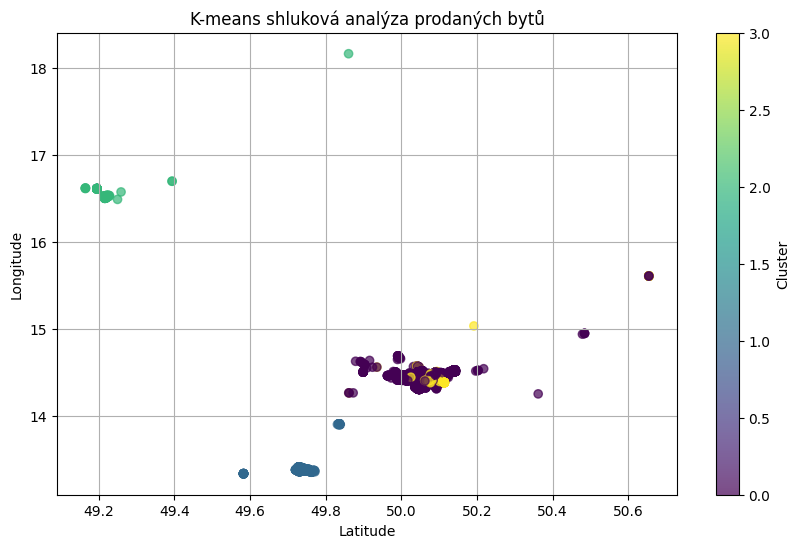

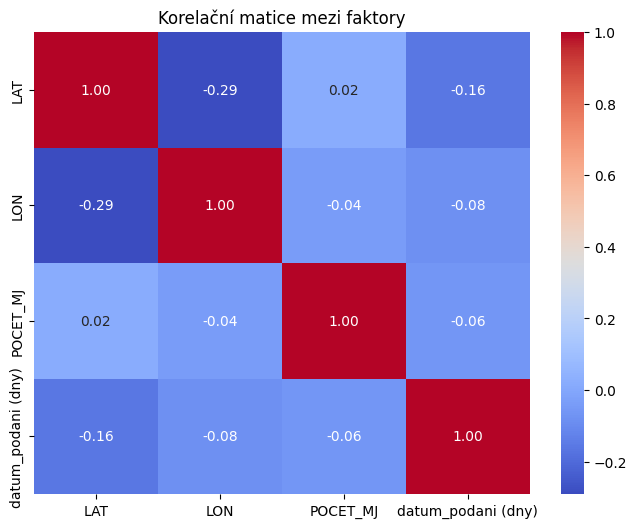

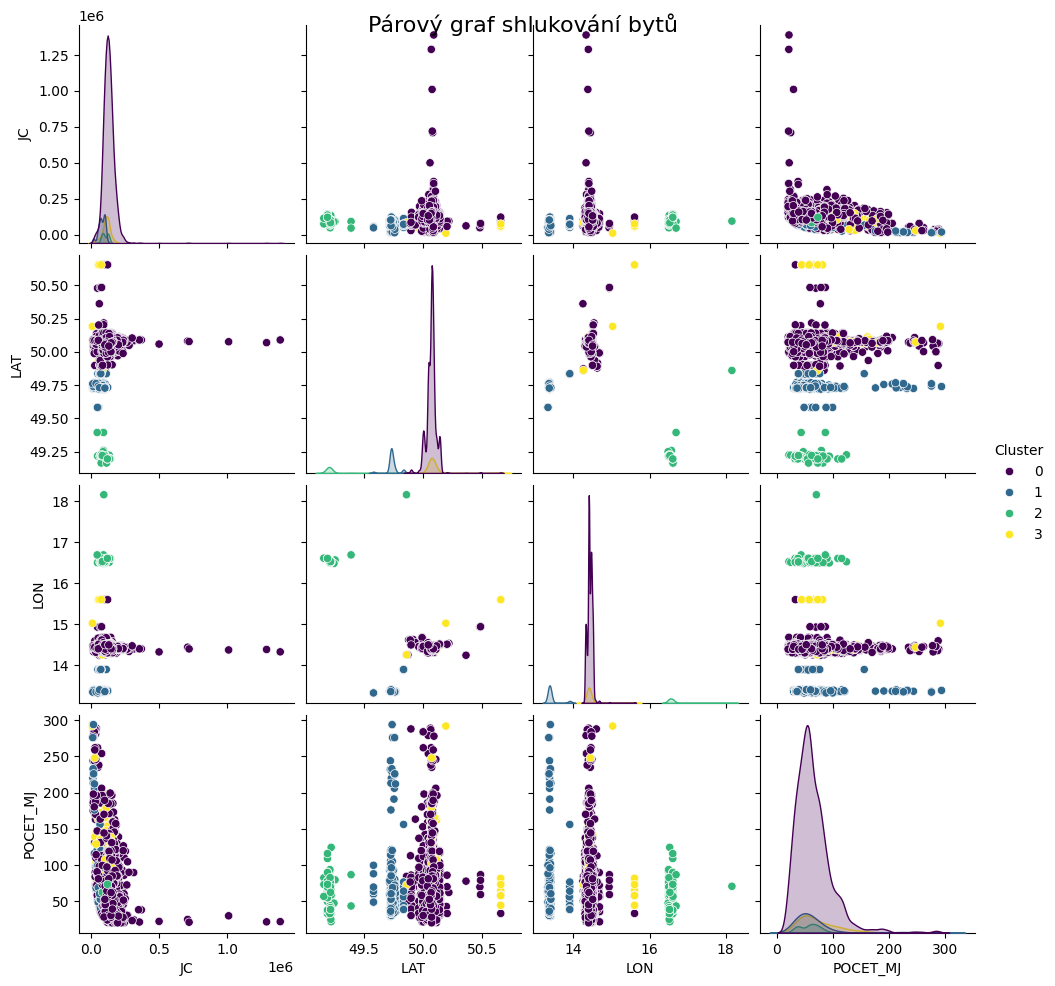


üìä V√Ωsledky model≈Ø:
Line√°rn√≠ regrese: R¬≤ = 0.109, MSE = 2708173202.44


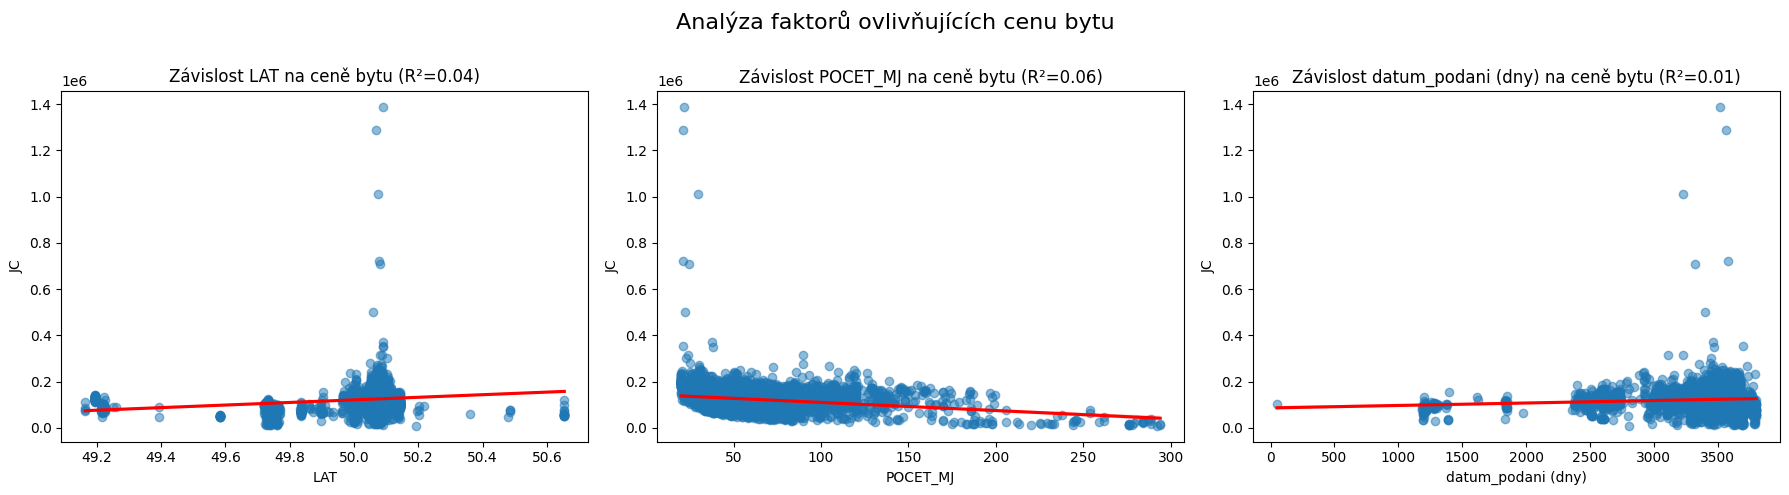

          cislo_vkladu        listina        datum_podani   rok  mesic  \
0     V-10250/2024-101  Smlouva kupn√≠ 2024-02-21 11:11:40  2024      3   
1     V-10343/2024-405  Smlouva kupn√≠ 2024-10-22 16:22:34  2024     11   
2     V-10384/2024-101  Smlouva kupn√≠ 2024-02-21 13:26:30  2024      3   
3     V-10514/2024-405  Smlouva kupn√≠ 2024-10-29 09:28:20  2024     11   
4     V-10693/2024-405  Smlouva kupn√≠ 2024-11-01 12:30:00  2024     11   
...                ...            ...                 ...   ...    ...   
5878   V-9284/2024-405  Smlouva kupn√≠ 2024-09-25 11:04:47  2024     11   
5879     V-93/2024-101  Smlouva kupn√≠ 2024-01-02 13:15:02  2024      1   
5882   V-9664/2024-101  Smlouva kupn√≠ 2024-02-19 12:40:50  2024      3   
5883   V-9810/2024-101  Smlouva kupn√≠ 2024-02-19 15:39:50  2024      3   
5884   V-9965/2024-405  Smlouva kupn√≠ 2024-10-11 10:05:52  2024     11   

                   okres kat_uzemi  \
0     Hlavn√≠ mƒõsto Praha   Sm√≠chov   
1            Plze≈à-mƒ

In [ ]:

def analyze_real_estate_data(engine, query, enable_visuals=True, pairplot_vars=None):
    """
    Analyzuje data o cen√°ch byt≈Ø v Praze, prov√°d√≠ shlukovou anal√Ωzu a predikuje ceny.
    :param engine: P≈ôipojen√≠ k datab√°zi.
    :param query: SQL dotaz pro naƒçten√≠ dat.
    :param enable_visuals: Ovl√°d√°n√≠ vizualizac√≠ pro rychlej≈°√≠ bƒõh.
    :param pairplot_vars: Seznam sloupc≈Ø pro p√°rov√Ω graf (voliteln√©).
    """
    # 1Ô∏è‚É£ Naƒçten√≠ dat z datab√°ze
    df = pd.read_sql(query, engine)


    # Ovƒõ≈ôen√≠, zda jsou po≈æadovan√© sloupce v datech
    required_columns = ['datum_podani', 'LAT', 'LON', 'JC', 'POCET_MJ']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Chybƒõj√≠c√≠ sloupce v datech: {missing_columns}")

    # P≈ôevod data na datetime a v√Ωpoƒçet dn≈Ø od zaƒç√°tku
    df['datum_podani'] = pd.to_datetime(df['datum_podani'], dayfirst=True, errors='coerce')
    df['datum_podani (dny)'] = (df['datum_podani'] - df['datum_podani'].min()).dt.days

    # Odstranƒõn√≠ ≈ô√°dk≈Ø s chybƒõj√≠c√≠mi hodnotami
    df = df.dropna(subset=['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)'])

    # 2Ô∏è‚É£ Normalizace dat pro K-means
    scaler = StandardScaler()
    #features = ['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)']
    #X_scaled = scaler.fit_transform(df[features])

    features = ['LAT', 'LON', 'POCET_MJ', 'datum_podani (dny)']  # Odstranƒõn sloupec 'JC'
    X_scaled = scaler.fit_transform(df[features + ['JC']])  # P≈ôid√°n sloupec 'JC' pro normalizaci

    # 3Ô∏è‚É£ Shlukov√° anal√Ωza (K-means)
    k = 4
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=300)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    if enable_visuals:
        # 4Ô∏è‚É£ Vizualizace shluk≈Ø podle polohy
        plt.figure(figsize=(10, 6))
        plt.scatter(df['LAT'], df['LON'], c=df['Cluster'], cmap='viridis', marker='o', alpha=0.7)
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title('K-means shlukov√° anal√Ωza prodan√Ωch byt≈Ø')
        plt.colorbar(label='Cluster')
        plt.grid(True)
        plt.show()

        # 5Ô∏è‚É£ Korelaƒçn√≠ anal√Ωza
        plt.figure(figsize=(8, 6))
        sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Korelaƒçn√≠ matice mezi faktory')
        plt.show()

        # 6Ô∏è‚É£ P√°rov√Ω graf pro shlukov√°n√≠
        if pairplot_vars:
            selected_vars = [var for var in pairplot_vars if var in df.columns]
        else:
            selected_vars = ['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)']

        sampled_df = df.sample(n=min(5000, len(df)), random_state=42)
        sns.pairplot(sampled_df[selected_vars + ['Cluster']], hue='Cluster', diag_kind='kde', palette='viridis')
        plt.suptitle('P√°rov√Ω graf shlukov√°n√≠ byt≈Ø', fontsize=16)
        plt.show()

    # 7Ô∏è‚É£ Predikce cen byt≈Ø
    X = df[['LAT', 'LON', 'POCET_MJ', 'datum_podani (dny)']]
    y = df['JC']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model 1: Line√°rn√≠ regrese
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lr = lin_reg.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)

    # Model 2: Random Forest
    rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_reg.fit(X_train, y_train)
    y_pred_rf = rf_reg.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf)

    print("\nüìä V√Ωsledky model≈Ø:")
    print(f"Line√°rn√≠ regrese: R¬≤ = {r2_lr:.3f}, MSE = {mean_squared_error(y_test, y_pred_lr):.2f}")
    #axes[i].set_ylabel('JC')

    if enable_visuals:
        # 8Ô∏è‚É£ Grafy z√°vislost√≠ faktor≈Ø na cenƒõ vƒçetnƒõ R¬≤
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        factors = ['LAT', 'POCET_MJ', 'datum_podani (dny)']

        for i, factor in enumerate(factors):
            sns.regplot(ax=axes[i], x=df[factor], y=df['JC'], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
            r2 = r2_score(df['JC'], LinearRegression().fit(df[[factor]], df['JC']).predict(df[[factor]]))
            axes[i].set_title(f'Z√°vislost {factor} na cenƒõ bytu (R¬≤={r2:.2f})')
            axes[i].set_ylabel('JC')

        plt.suptitle('Anal√Ωza faktor≈Ø ovliv≈àuj√≠c√≠ch cenu bytu', fontsize=16)
        plt.tight_layout()
        plt.show()

    return df

vybrane_sloupce = ['JC', 'LAT', 'LON', 'POCET_MJ', 'datum_podan (dny)']
df = analyze_real_estate_data(engine, query, enable_visuals=True, pairplot_vars=vybrane_sloupce)

